## Preamble

This is the follow-up analysis of the e-commerce Olist' dataset.
In a <a href="https://github.com/Camille-Le-Roy/E-Commerce-Data-Processing-Pipeline" target="_blank" style="color:#D0D0D0; text-decoration:underline;">previous analysis</a>, we have prepared the dataset by merging 9 tables into 3 Analytical Base Table.
- order level dataset ('orders_merged.csv')
- product level dataset ('order_items_merged.csv')
- customer level dataset ('customers_level_dataset.csv')

In a <a href="https://github.com/Camille-Le-Roy/E-Commerce-Sales-Trends-and-Customer-Analysis" target="_blank" style="color:#D0D0D0; text-decoration:underline;">second analysis</a>, the clustering of customers highlighted that
one of the cluster was defined by customers experiencing delivery delays, pointing at potential service and logistics issues.

Here, we will focus on identifying the factors that best predict delivery delays to clarify this issue.

#### Loading datasets

In [10]:
# Importing the libraries
import os
import pandas as pd
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
np.random.seed(42)

local_path = Path.cwd()

# path to data folder
data_folder = local_path / "data" / "Olist ecommerce dataset" / "processed_datasets"

# load the Analytical Base Tables (ABTs):
df_orders = pd.read_csv(data_folder / "orders_merged.csv", low_memory=False) # order level dataset
df_products = pd.read_csv(data_folder / "order_items_merged.csv", low_memory=False) # product level dataset
df_customers = pd.read_csv(data_folder / "customers_level_dataset.csv", low_memory=False) # customer level dataset

### Preparing Data

In [11]:
print(f"There are {df_orders.shape[0]} individual orders in the datasets")

There are 98816 individual orders in the datasets


In [12]:
print(df_orders.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98816 entries, 0 to 98815
Data columns (total 47 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       98816 non-null  object 
 1   customer_id                    98816 non-null  object 
 2   order_status                   98816 non-null  object 
 3   order_purchase_timestamp       98816 non-null  object 
 4   order_approved_at              98797 non-null  object 
 5   order_delivered_carrier_date   97583 non-null  object 
 6   order_delivered_customer_date  96470 non-null  object 
 7   order_estimated_delivery_date  98816 non-null  object 
 8   delivery_delay                 96470 non-null  float64
 9   purchase_to_delivery_days      96470 non-null  float64
 10  price                          98205 non-null  float64
 11  freight_value                  98205 non-null  float64
 12  n_items                        98205 non-null 

In [13]:
print(f"number of unique values per column:\n {df_orders.nunique()}")

number of unique values per column:
 order_id                         98816
customer_id                      98816
order_status                         7
order_purchase_timestamp         98257
order_approved_at                90301
order_delivered_carrier_date     80951
order_delivered_customer_date    95658
order_estimated_delivery_date      448
delivery_delay                     198
purchase_to_delivery_days          146
price                             7577
freight_value                     7676
n_items                             17
payment_value                    27602
payment_sequential                  20
payment_type                         4
avg_review                          11
customer_unique_id               95560
customer_zip_code_prefix         14982
customer_city                     4117
customer_state                      27
distance_km                      91831
order_year                           3
order_month                         12
order_day_of_week          

#### Convert date columns to proper datetime type

In [14]:
df_orders['order_delivered_carrier_date'] = pd.to_datetime(df_orders['order_delivered_carrier_date'], errors='coerce')
df_orders['order_delivered_customer_date'] = pd.to_datetime(df_orders['order_delivered_customer_date'], errors='coerce')
df_orders['order_estimated_delivery_date'] = pd.to_datetime(df_orders['order_estimated_delivery_date'], errors='coerce')

#### Check for missing values

In [15]:
df_orders.isnull().sum()
### remove all NAs from the dataset:
df_orders = df_orders.dropna()
print("The number of rows in the dataset after removing NAs is:", len(df_orders))

The number of rows in the dataset after removing NAs is: 95936


#### Check for "inf/-inf" values

In [16]:
num_feat = df_orders.select_dtypes(include=[np.number]).columns.tolist()
np.isinf(df_orders[num_feat].select_dtypes(include=[np.number])).any() # ---> no "inf" values in the order level dataset

delivery_delay               False
purchase_to_delivery_days    False
price                        False
freight_value                False
n_items                      False
payment_value                False
payment_sequential           False
avg_review                   False
customer_zip_code_prefix     False
distance_km                  False
order_year                   False
order_month                  False
order_day_of_week            False
order_hour                   False
is_weekend                   False
is_holiday_season            False
approval_delay_hours         False
carrier_pickup_days          False
avg_price_per_item           False
freight_percentage           False
total_order_value            False
revenue_per_km               False
is_high_value                False
is_late                      False
is_satisfied                 False
logistics_complexity         False
customer_order_count         False
customer_lifetime_value      False
days_since_last_orde

#### Check for highly correlated numerical features

In [ ]:
from scipy.cluster import hierarchy as hc

def cluster_columns(df):
    corr = df.corr()
    corr_condensed = hc.distance.squareform(1 - corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=(6, 4))
    dendrogram = hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=10)
    plt.show()
    plt.tight_layout()

cluster_columns(df_orders[num_feat])


In [ ]:
## based on the dendrogram, we exclude the redundant features:
redundant_num_features = ['is_repeat_customer', 'avg_review', 'logistics_complexity','purchase_to_delivery_days','payment_value',
                          'customer_lifetime_value', 'avg_price_per_item','order_day_of_week','price']

df_orders_reduced = df_orders.copy().drop(columns=redundant_num_features)
cluster_columns(df_orders_reduced.select_dtypes(include=[np.number])) # check again after removing redundant features

#### Remove not-relevant features (that are either identifiers or data leakage)

---> Data Leakage: it's important to remove any feature that is a direct calculation of the target variable
Any feature whose value would be unknown at the time we need to make the prediction. If we leave it, the model will 'cheat' using these proxies.

In [18]:
drop_cols = [
    'order_id', 'customer_id', 'customer_unique_id', 'customer_last_order',
    'customer_state', # a first analysis revealed that this introduces bias
    'order_purchase_timestamp', 'order_approved_at',          # remove raw timestamps because we already extracted year/month/hour
    # the features below may cause data leakage:
    'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date',
    'delivery_speed', 'delivery_delay', 'delivery_status', 'review_category', 'is_satisfied'
]
# These columns serve only to uniquely identify rows and contain no predictive information about the target variable
df_orders_reduced = df_orders_reduced.copy().drop(columns=drop_cols)

#### Define target and independent variables

In [19]:
### Target: we use 'is_late' (binary 0/1). If we prefer regression, use can also use 'delivery_delay'
y = df_orders_reduced['is_late'].astype(int)
### Features: all other columns except the target
X = df_orders_reduced.drop(columns='is_late')

print("Candidate features:\n", X.dtypes)

Candidate features:
 order_status                 object
freight_value               float64
n_items                     float64
payment_sequential          float64
payment_type                 object
customer_zip_code_prefix      int64
customer_city                object
distance_km                 float64
order_year                    int64
order_month                   int64
order_hour                    int64
is_weekend                    int64
is_holiday_season             int64
approval_delay_hours        float64
carrier_pickup_days         float64
freight_percentage          float64
total_order_value           float64
revenue_per_km              float64
is_high_value                 int64
distance_category            object
customer_order_count          int64
days_since_last_order         int64
dtype: object


#### Identify numeric and categorical features

In [20]:
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)

Numeric cols: ['freight_value', 'n_items', 'payment_sequential', 'customer_zip_code_prefix', 'distance_km', 'order_year', 'order_month', 'order_hour', 'is_weekend', 'is_holiday_season', 'approval_delay_hours', 'carrier_pickup_days', 'freight_percentage', 'total_order_value', 'revenue_per_km', 'is_high_value', 'customer_order_count', 'days_since_last_order']
Categorical cols: ['order_status', 'payment_type', 'customer_city', 'distance_category']


#### Make dummies for categorical features

In [21]:
# For tree models scaling isn't actually required. We make dummies for small-cardinality cats.
# Drop very-high-cardinality categorical fields (like city if huge) or reduce them (top-k + 'OTHER').
def reduce_cardinality(df, col, top_k=20):
    top = df[col].value_counts().nlargest(top_k).index
    return df[col].where(df[col].isin(top), other='__OTHER__')

print(f"number of unique values per column:\n {X[cat_cols].nunique()}")

number of unique values per column:
 order_status            1
payment_type            4
customer_city        4034
distance_category       4
dtype: int64


In [22]:
# ---> 'customer_city' has huge cardinality (more than 400 unique values)
# reduce the cardinality for 'customer_city':
X['customer_city'] = reduce_cardinality(X, 'customer_city', top_k=30)

print(X['customer_city'].value_counts()) # now most city are grouped into the level '__OTHER__', and the top 20 have separated level

customer_city
__OTHER__                51316
sao paulo                14998
rio de janeiro            6576
belo horizonte            2690
brasilia                  1905
curitiba                  1484
campinas                  1401
porto alegre              1335
salvador                  1183
guarulhos                 1142
sao bernardo do campo      908
niteroi                    823
santo andre                775
osasco                     723
santos                     696
sao jose dos campos        667
goiania                    658
fortaleza                  616
sorocaba                   608
recife                     593
florianopolis              554
jundiai                    548
ribeirao preto             498
belem                      431
juiz de fora               422
nova iguacu                422
barueri                    419
contagem                   414
sao goncalo                385
mogi das cruzes            374
vitoria                    372
Name: count, dtype: int64

In [23]:

# Select categorical columns to one-hot encode (exclude those still too high-card)
cat_cols = [c for c in cat_cols if (X[c].nunique() <= 50)] # count how many distinct values it contains and filter to those with <= 50 unique values
print("One-hot encoding these cats:", cat_cols)

X_proc = X.copy()
# one-hot encode the variable in 'cat_cols'
X_proc = pd.get_dummies(X_proc, columns=cat_cols, drop_first=True, dtype=np.int8)
print(f"Shape after one-hot encoding: {X_proc.shape}")

One-hot encoding these cats: ['order_status', 'payment_type', 'customer_city', 'distance_category']
Shape after one-hot encoding: (95936, 54)


#### Plot delivery delay

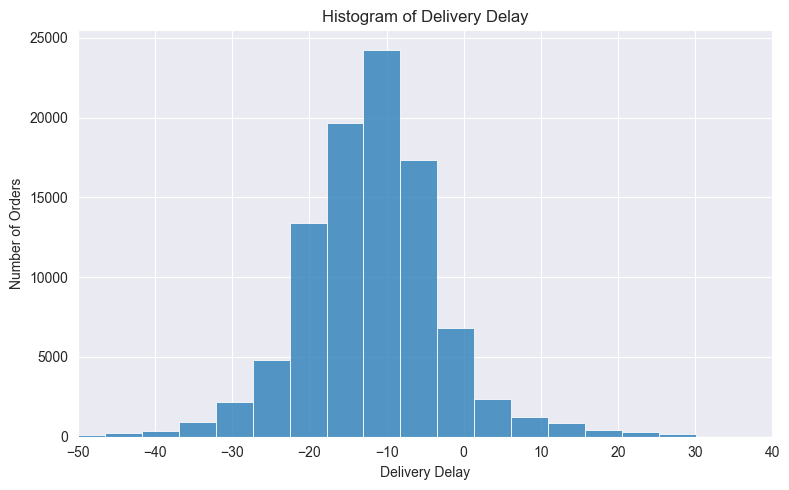

Most order are delivered in time. 
There are nonetheless 6484 late delivery recorded, representing 6.76% of the total number of orders


In [24]:
## Here we explore pattern of delivery delay in the data, which may influence modeling decision

fig, ax = plt.subplots(figsize=(8,5))
sns.histplot(df_orders['delivery_delay'], bins=70, kde=False, ax=ax)
ax.set_xlabel('Delivery Delay') ; ax.set_ylabel('Number of Orders') ;ax.set_title('Histogram of Delivery Delay')
ax.set_xlim(-50,40)
plt.tight_layout()
plt.show()

print(f"Most order are delivered in time. \n"
      f"There are nonetheless {(df_orders.delivery_delay>0).sum()} late delivery recorded,"
      f" representing {int((df_orders.delivery_delay>0).sum())*100/df_orders.shape[0]:.2f}% of the total number of orders")

## XGBoost Modelling Delay

Here we ask what combination of order, logistics, and customer features best predicts whether a delivery will be late.
To answer this, we model the delivery delay using the Gradient Boosting library "XGBoost".

Principle:

XGBoost is an 'Ensemble learning' method: It combines many weak decision trees to create a single strong predictive model.
It can be viewed as a smart for-loop that builds decision trees one after another, each one trying to fix the mistakes the previous ones made.
 - It starts with the simplest possible prediction, like a global average guess for example.
 - Then it builds a small decision tree that predicts where the first guess was too high or too low, and update/correct the previous prediction.
 - Then it repeats:
     - Compute what’s still wrong (the residuals).
     - Fit a new tree to those errors.
     - Add that tree’s output to the running total.

#### Define train/valid/test split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.2, random_state=42, stratify=y)

stratify = y: important parameter when dealing with imbalanced datasets.
---> Stratification ensures that both the training set and the testing set have
the same proportion of observations for each class (or category)as the original target variable y
(for example 30% late and 70% on-time deliveries in both train and test sets).

#### Baseline XGBoost model

In [26]:
clf = xgb.XGBClassifier( # clf for "classifier" (not that it would be 'Regressor' if modelling a continuous target)
    objective='binary:logistic', # Specifies the objective function for binary classification. 'binary:logistic' will render probabilities (0 to 1)
    eval_metric='auc', # 'Area Under the Curve' the evaluation metric to monitor during training
    n_jobs=-1, # Uses all available processor cores (-1) for parallel computation, speeding up training.
    random_state=42 # random number seed for reproducibility
)

#### Baseline fit

In [27]:
clf.fit(X_train, y_train) # Train the model. The XGBoost classifier (clf) learns the relationship between the features (X_train) and the target variable (y_train).

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


#### Predict

In [28]:
y_pred = clf.predict(X_test) # Generate the "hard" predictions (binary 0 or 1) for the unseen test set (X_test).

y_proba = clf.predict_proba(X_test)[:, 1] # Generates the predicted probabilities for the test set.
# predict_proba returns a 2-column array: [probability of 0, probability of 1]. '[:, 1]' return only the probability of 'is_late' being True.

#### Evaluate performance of the baseline model

In [29]:
print("ROC AUC (baseline):", roc_auc_score(y_test, y_proba))
# The ROC AUC (Receiver Operating Characteristic - Area Under the Curve) measures the model's ability to distinguish between positive and negative classes.
# ---> The 'roc_auc_score' ranges from 0.5 to 1.0.  1.0 = perfect classification ; 0.5 same as random guessing.

ROC AUC (baseline): 0.8270455069154958


In [30]:

print(classification_report(y_test, y_pred)) # return a set of performance metrics
# - Precision (Positive Predictive Value): Out of all instances the model predicted as positive, how many were actually positive? (= false positives).
# - Recall (Sensitivity): Out of all instances that were actually positive, how many did the model correctly identify? (= false negatives).
# - F1-Score: The harmonic mean of Precision and Recall, providing a single metric that balances both
# - Support: The actual number of occurrences of each class in the test set.
# - Macro Avg / Weighted Avg: Averages of the scores across all classes.

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     17891
           1       0.53      0.15      0.23      1297

    accuracy                           0.93     19188
   macro avg       0.74      0.57      0.60     19188
weighted avg       0.91      0.93      0.92     19188



#### Plot confusion matrix plot

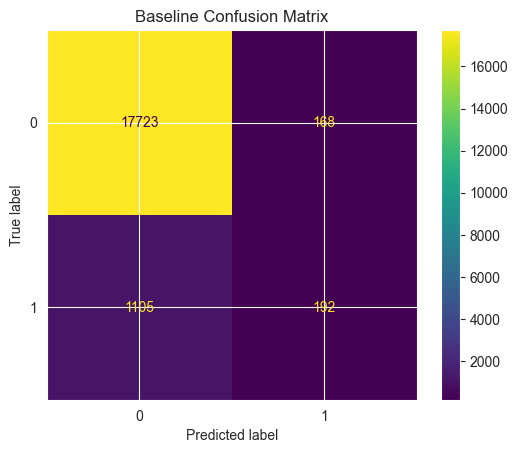

In [31]:
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Baseline Confusion Matrix")
plt.show()

#### Plot feature importance
---> at this stage, data leakage can be easily detected if some features overly predict the target variable!

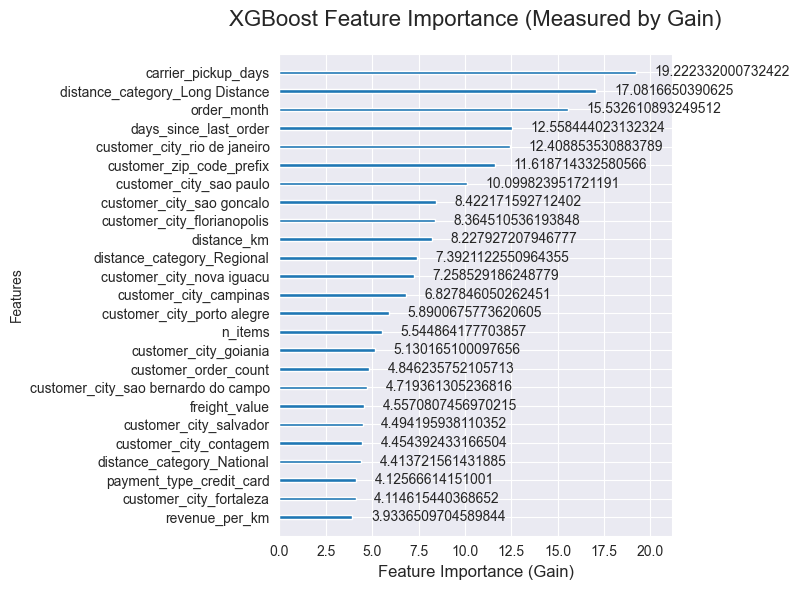

In [32]:
fig, ax = plt.subplots(figsize=(8,6))
xgb.plot_importance(clf, importance_type='gain', max_num_features=25, ax=ax, color='#1F77B4')
ax.set_title("XGBoost Feature Importance (Measured by Gain)", fontsize=16, pad=20 )
ax.set_xlabel("Feature Importance (Gain)", fontsize=12)
# Ensure feature names (y-axis labels) are clearly visible
ax.tick_params(axis='y', labelsize=10)
plt.tight_layout()
plt.show()

### Tune with Early Stopping

It's always good practice to train the model with 'Early Stopping',
which let XGBoost automatically decide when it has trained enough trees, before it starts to overfit.

Here we want to have a validation data subset to monitor performance during training to implement early stopping.
The original X_train is split again to create a subset for training (X_train_full):

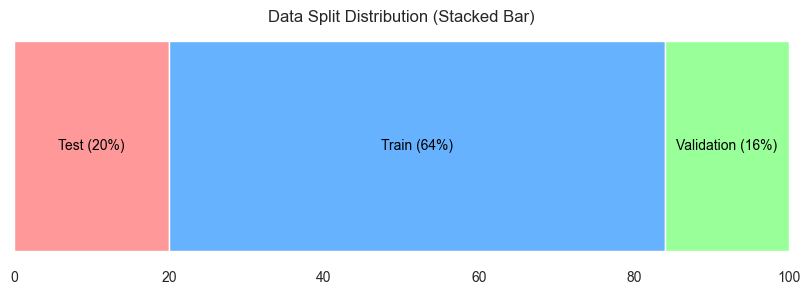

In [33]:
X_train_full, X_valid, y_train_full, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

### Visualize the dataset splitting
sizes = [20, 64, 16] ; labels = ['Test (20%)', 'Train (64%)', 'Validation (16%)']
colors = ['#FF9999', '#66B2FF', '#99FF99']  # optional nice colors
plt.figure(figsize=(10, 3))
left = 0
for size, label, color in zip(sizes, labels, colors):
    plt.barh(0, size, left=left, color=color)
    plt.text(left + size/2, 0, f"{label}", va='center', ha='center', fontsize=10, color='black')
    left += size
plt.xlim(0, 100)
plt.yticks([])  # remove y-axis
plt.box(False)
plt.title("Data Split Distribution (Stacked Bar)")
plt.show()


#### Define the model with parameters tuned for early stopping

In [34]:
clf_es = xgb.XGBClassifier(
    objective='binary:logistic',     # Sets objective for binary classification (outputs probabilities)
    eval_metric='auc',               # Sets Area Under the Curve (AUC) as the metric to monitor
    n_estimators=1000,               # Sets a large upper bound of nb of trees for boosting rounds; training will stop early
    learning_rate=0.05,              # Uses a smaller learning rate for smoother convergence, compensating for the high n_estimators
    random_state=42,                 # Ensures model initialization is reproducible
    n_jobs=-1  ,                     # Uses all available processor cores for faster training
    early_stopping_rounds=30         # The training will stop if the AUC does not improve for 30 consecutive boosting rounds. This prevents overfitting.
)

#### Train the model, monitoring performance on the validation set

In [35]:
clf_es.fit(
    X_train_full, y_train_full,
    eval_set=[(X_valid, y_valid)], # The validation set used to monitor performance after each boosting round
    verbose=True # Prints evaluation results to the console for monitoring
)
# ---> The training process continued for 30 rounds after the best score was achieved.

[0]	validation_0-auc:0.77409
[1]	validation_0-auc:0.78968
[2]	validation_0-auc:0.79063
[3]	validation_0-auc:0.79329
[4]	validation_0-auc:0.79290
[5]	validation_0-auc:0.79299
[6]	validation_0-auc:0.79622
[7]	validation_0-auc:0.80038
[8]	validation_0-auc:0.80242
[9]	validation_0-auc:0.80401
[10]	validation_0-auc:0.80460
[11]	validation_0-auc:0.80515
[12]	validation_0-auc:0.80539
[13]	validation_0-auc:0.80969
[14]	validation_0-auc:0.81198
[15]	validation_0-auc:0.81306
[16]	validation_0-auc:0.81432
[17]	validation_0-auc:0.81554
[18]	validation_0-auc:0.81610
[19]	validation_0-auc:0.81655
[20]	validation_0-auc:0.81678
[21]	validation_0-auc:0.81681
[22]	validation_0-auc:0.81807
[23]	validation_0-auc:0.81988
[24]	validation_0-auc:0.82047
[25]	validation_0-auc:0.82068
[26]	validation_0-auc:0.82202
[27]	validation_0-auc:0.82217
[28]	validation_0-auc:0.82208
[29]	validation_0-auc:0.82294
[30]	validation_0-auc:0.82341
[31]	validation_0-auc:0.82455
[32]	validation_0-auc:0.82530
[33]	validation_0-au

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,30
,enable_categorical,False
,eval_metric,'auc'


#### Evaluate Performance

In [36]:
y_proba_es = clf_es.predict_proba(X_test)[:, 1] # Predict probabilities on the held-out TEST set (X_test)
## Calculate the final performance metric (ROC AUC) using the true labels (y_test) and the predicted probabilities (y_proba_es):
print("Test ROC AUC with early stopping:", roc_auc_score(y_test, y_proba_es))

Test ROC AUC with early stopping: 0.8360449836146903


### Tune with RandomizedSearchCV

Unlike random forests, gradient boosted trees are extremely sensitive to the choices of these hyperparameters;
several methods exists to try different hyperparameters to find the ones that work best.
For example, the 'GridSearchCV' is a method trying every possible combination ot parameters. It can be quite long on big dataset
Here we are using 'RandomizedSearchCV', which samples a random subset of combinations. It is much faster, and often finds just-as-good results.

The parameters we can tweak to improve (or reduce) the model performance are generally the following:

 | Parameter (Name)         | Controls (Purpose)                              | Analogy (Intuition)
 | ------------------------ | ----------------------------------------------- | -------------------------------------------------
 | `n_estimators`           | Total number of trees/boost rounds              | “How many total iterations of improvement do I run?”
 | `max_depth`              | Maximum tree complexity                         | “How complex can each decision rule set be?”
 | `learning_rate`          | Step size for each new tree's contribution      | “How cautiously/slowly do I learn from mistakes?”
 | `subsample`              | % of rows sampled per tree                      | “Should I use row-level randomness to reduce variance (overfitting)?”
 | `colsample_bytree`       | % of features sampled per tree                  | “Should I use feature-level randomness to reduce variance?”
 | `scale_pos_weight`       | Weighting of the minority class (1)             | “How much should I emphasize/upweight the rare 'late' cases?”

#### Define parameter space

In [37]:
# Dictionary where keys are XGBoost hyperparameters and values are lists of potential values to test.
param_dist = {
    'n_estimators': [500, 1000],              # Sets a large upper limit for the number of trees/rounds (The actual number will be determined by early stopping).
    'max_depth': [3, 4, 5, 6, 8],             # Controls the complexity of each individual tree.
    'learning_rate': [0.01, 0.05, 0.1],       # Controls the step size shrinkage. Smaller values require more trees.
    'subsample': [0.6, 0.8, 1.0],             # The fraction of rows (samples) randomly selected for building each tree.
    'colsample_bytree': [0.6, 0.8, 1.0],      # The fraction of columns (features) randomly selected for building each tree.
    'scale_pos_weight': [1, 2, 5, 10]         # Used to adjust the weight of the minority class (positive/late cases)
                                              # to handle imbalanced data (OUR CASE!). Higher values give more importance to the minority class.
}

#### Base model

In [38]:
# Initialize the XGBoost Classifier with non-tuning parameters.
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    random_state=42,
    n_jobs=-1
)

#### Randomized search setup

In [39]:
# Initializes the RandomizedSearchCV object from scikit-learn.
rand_search = RandomizedSearchCV(
    estimator=xgb_clf,                        # The base model to be tuned.
    param_distributions=param_dist,           # The dictionary defining the hyperparameter space define earlier.
    n_iter=20,                                # Number of random combinations of parameters to sample and test. This limits the total search time.
    scoring='roc_auc',                        # The metric used to evaluate and rank the results of each combination during cross-validation.
    cv=3,                                     # Number of cross-validation folds (k=3). The training set is split into 3 parts, and the model is trained 3 times.
    verbose=1,                                # Controls the level of output/logging printed during the search process.
    n_jobs=-1,
    random_state=42
)

#### Execute the Randomized Search Cross-Validation to find the optimal set of hyperparameters for your XGBoost model.

In [40]:
rand_search.fit(X_train, y_train) # --> may take some time to run

print("Best params:", rand_search.best_params_) # Best hyperparameters found during the cross-validation process.
print("Best CV AUC:", rand_search.best_score_) # Highest cross-validated score (ROC AUC) achieved by the best parameter set.

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params: {'subsample': 0.8, 'scale_pos_weight': 2, 'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Best CV AUC: 0.8445709948063298


In [41]:
## Use best model
## Extracts the best performing model instance (an XGBClassifier object) found by the search.
## This model is automatically trained using the best parameters on the entire X_train dataset.
best_model = rand_search.best_estimator_

## Evaluate on test data
## Generate the predicted probabilities for the positive class (class 1) using the
## completely unseen test features (X_test). This is the final, unbiased performance check.
y_proba_best = best_model.predict_proba(X_test)[:, 1]

## Calculate and print the final ROC AUC score using the true test labels (y_test) and the
## predicted probabilities. This score is the definitive measure of the model's generalization ability.
print("Test ROC AUC (best random search model):", roc_auc_score(y_test, y_proba_best))

Test ROC AUC (best random search model): 0.8398712032733815


#### Plot confusion matrix

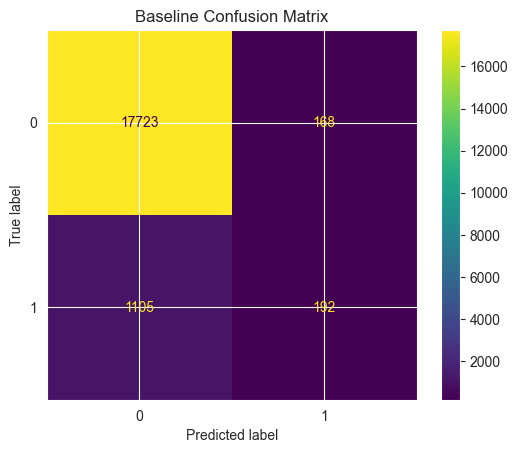

In [42]:
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Baseline Confusion Matrix")
plt.show()

---> The confusion matrix shows that the model performs well at identifying on-time deliveries but is bad at flagging late ones.
     Out of all true late deliveries, only 192 were correctly predicted, while 1,105 were missed.
     Let's make the model more sensitive to late deliveries (increase recall), by lowering the threshold, e.g., to 0.3.

In [43]:
# use 0.3 instead of 0.5 for classifying a late delivery
threshold = 0.3
y_pred_custom = (y_proba_best >= threshold).astype(int)
# Evaluate performance with lower threshold:
cm = confusion_matrix(y_test, y_pred_custom)
print("Confusion Matrix (threshold = 0.3):")
print(cm)

Confusion Matrix (threshold = 0.3):
[[16735  1156]
 [  716   581]]


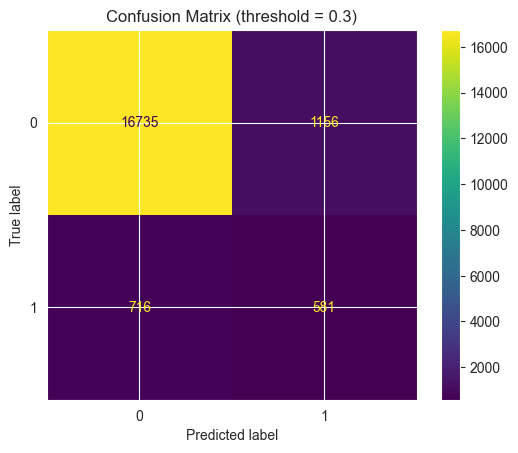

In [44]:
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_custom)
plt.title("Confusion Matrix (threshold = 0.3)")
plt.show()

---> Lowering the classification threshold allow catching more true delays at the expense of a more extra false positives,
 a trade-off that can be tuned based on business priorities (how costly are the false alarm?).

### Feature Importance Results

In [45]:
## Get feature importance's (gain-based by default)
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

## Display top features
print("\nTop 10 Important Features:")
print(feature_importance.head(10))


Top 10 Important Features:
                            Feature  Importance
11              carrier_pickup_days    0.075968
6                       order_month    0.058613
51  distance_category_Long Distance    0.046189
5                        order_year    0.044706
17            days_since_last_order    0.043243
3          customer_zip_code_prefix    0.036030
9                 is_holiday_season    0.033103
4                       distance_km    0.025971
41     customer_city_rio de janeiro    0.025681
46        customer_city_sao goncalo    0.022356


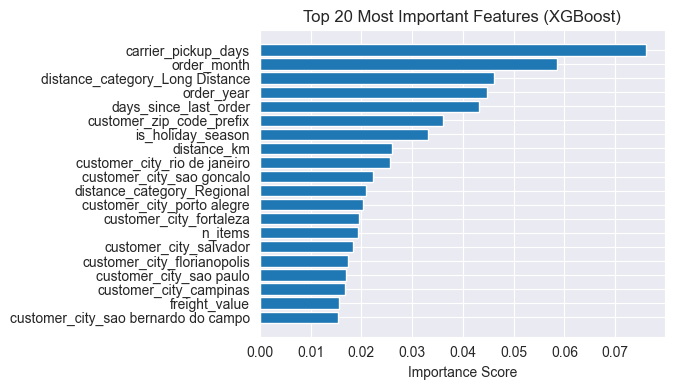

In [46]:

## Visualize top 20
plt.figure(figsize=(6,4))
plt.barh(feature_importance['Feature'][:20][::-1],
         feature_importance['Importance'][:20][::-1])
plt.xlabel("Importance Score")
plt.title("Top 20 Most Important Features (XGBoost)")
plt.tight_layout()
plt.subplots_adjust(left=0.3)
plt.show()

## Results Interpretation

#### FIRST ANALYSIS: including 'customer_state'

In [47]:
## When including 'customer_state' in the candidate features,
## These are the 4 most important predictor of late delivery:
#                             Feature  Importance
# 75                customer_state_SP    0.139037
# 68                customer_state_RJ    0.052349
# 11              carrier_pickup_days    0.044865
# 6                       order_month    0.033723

## ---> by far, the customer state (Sao Paulo and Rio de Janeiro) strongly predict the delivery delay
print(f"Orders from Sao Paulo state represent {(df_orders.customer_state == 'SP').sum()*100/df_orders.shape[0]:.2f}% of the data \n"
      f"Orders from Rio de Janeiro state represent {(df_orders.customer_state == 'RJ').sum()*100/df_orders.shape[0]:.2f}% of the data")

Orders from Sao Paulo state represent 42.09% of the data 
Orders from Rio de Janeiro state represent 12.82% of the data


<Axes: xlabel='customer_state', ylabel='is_late'>

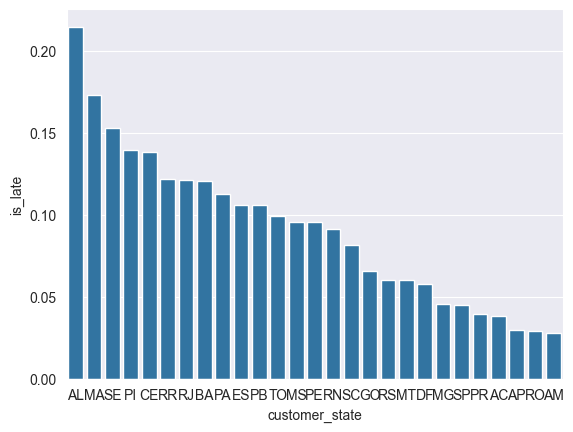

In [48]:
### investigate for difference between state
lateness_per_state = df_orders.groupby('customer_state')['is_late'].mean().sort_values(ascending=False)
sns.barplot(
    data=df_orders.groupby('customer_state')['is_late'].mean().sort_values(ascending=False).reset_index(),
    x='customer_state', y='is_late')

<Axes: xlabel='customer_state', ylabel='delivery_delay'>

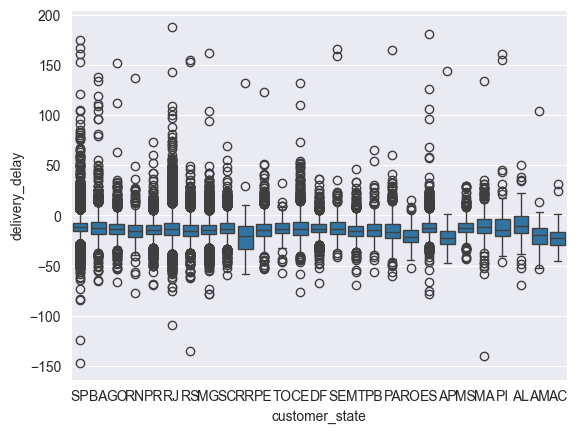

In [49]:
### ---> looks like SP has a low rate of late delivery (~5%), whereas Rio de Janeiro is at ~13%
### because there represent a lot of data points and have a low vs higher lateness rate, they are learned by the model as good predictors

### look at delivery delay (the continuous variable) per states:
sns.boxplot(data=df_orders, x='customer_state', y='delivery_delay')
### ---> variation in delivery delay in each state is quite comparable

### ---> We should re-run the analysis without 'customer_state' as a candidate feature

#### SECOND ANALYSIS: excluding 'customer_state'

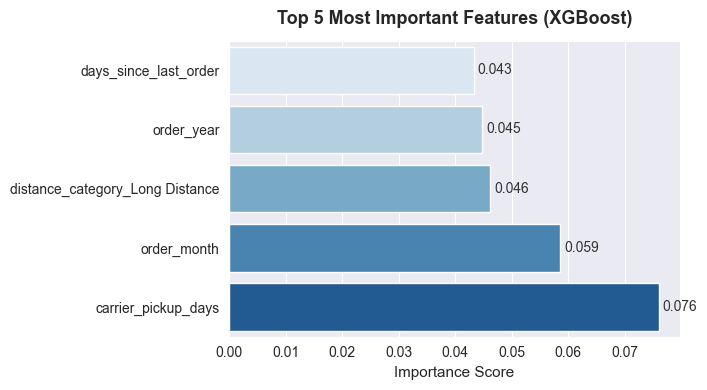

In [50]:
## These are the 5 most important predictor of late delivery:
#                            Feature  Importance
# 11              carrier_pickup_days    0.075968
# 6                       order_month    0.058613
# 51  distance_category_Long Distance    0.046189
# 5                        order_year    0.044706
# 17            days_since_last_order    0.043243

## plot the top 5 predictors
top_features = feature_importance.head(5).iloc[::-1]  # reverse the feature order for display order
plt.figure(figsize=(7, 4))
barplot = sns.barplot(
    data=top_features,
    y="Feature",
    x="Importance",
    hue="Feature",
    dodge=False,
    palette="Blues",
    legend=False
)
plt.title("Top 5 Most Important Features (XGBoost)", fontsize=13, weight='bold', pad=12)
plt.xlabel("Importance Score", fontsize=11)
plt.ylabel("")
plt.tight_layout()

# Add value labels on bars
for container in barplot.containers:
    barplot.bar_label(container, fmt="%.3f", label_type="edge", padding=3, fontsize=10, color="#333")
# plt.savefig('importance_chart.pdf')
plt.show()


#### Influence of 'carrier_pickup_days'

<Axes: xlabel='carrier_pickup_days', ylabel='delivery_delay'>

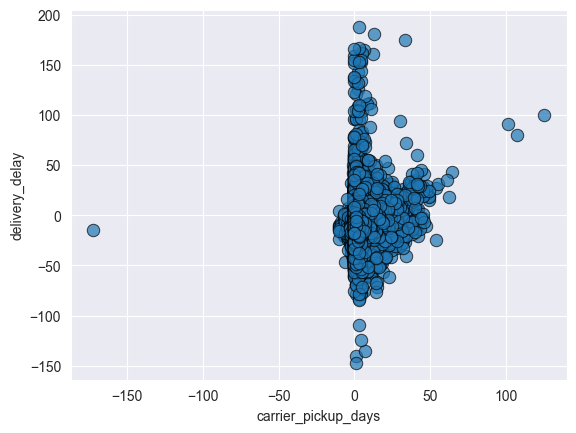

In [53]:
## 'carrier_pickup_days' is the time elapsed between the order being approved and the package being picked up by the shipping carrier.
## It reflects the seller's internal handling speed (in days). Could be considered as a too obvious predictor.

## is carrier_pickup_days correlated to delivery_delay?
sns.scatterplot(x='carrier_pickup_days', y='delivery_delay',data=df_orders,s=80, alpha=0.7,edgecolor='k')
## not that there is a huge outlier at delivery_delay.min() = -172

(-50.0, 40.0)

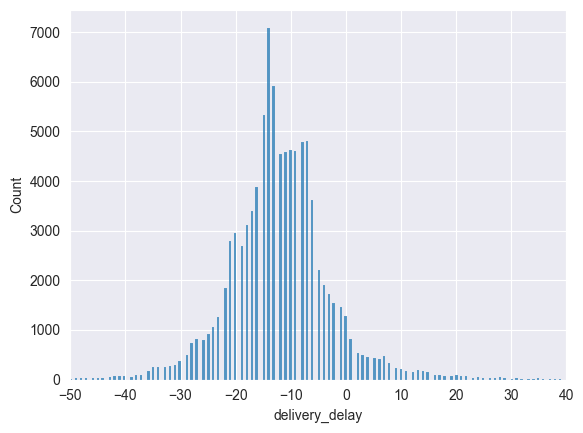

In [52]:
## check the distribution of delay
sns.histplot(data=df_orders.delivery_delay) ; plt.xlim(-50, 40) # positive value = late, negative value = early
### ---> not so many order are late (>0)

#### Influence of 'order_month'

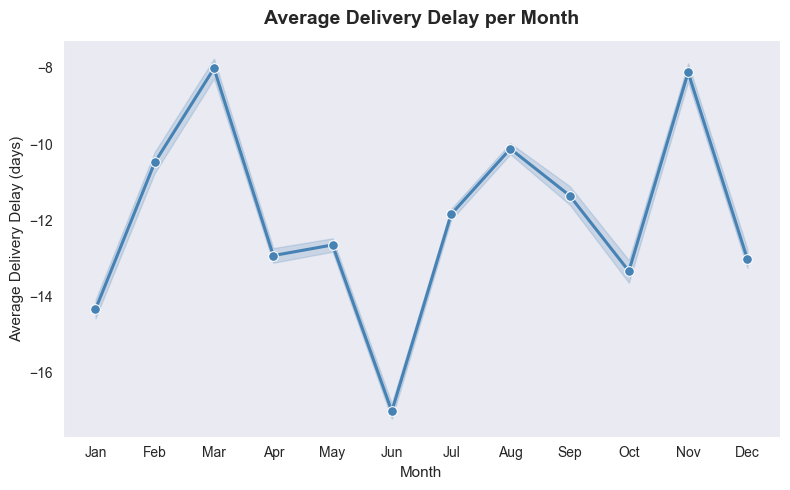

In [54]:
# Define month labels
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(8,5))
sns.lineplot(
    data=df_orders,
    x='order_month',
    y='delivery_delay',
    marker='o',
    color='steelblue',
    linewidth=2.2,
    markersize=7
)
plt.title("Average Delivery Delay per Month", fontsize=14, weight='bold', pad=12)
plt.xlabel("Month", fontsize=11)
plt.ylabel("Average Delivery Delay (days)", fontsize=11)
plt.xticks(ticks=range(1, 13), labels=months)# Replace numeric x-axis ticks with month abbreviations
# Remove grid background
sns.despine()                # removes top/right spines
plt.grid(False)              # disables all grid lines
plt.tight_layout()

In [56]:
#### proportion of late deliveries as a barplot:
late_by_month = df_orders.groupby('order_month')['is_late'].mean().reset_index()
print(late_by_month)

    order_month   is_late
0             1  0.054113
1             2  0.118823
2             3  0.151021
3             4  0.050066
4             5  0.053151
5             6  0.017982
6             7  0.031050
7             8  0.048622
8             9  0.043900
9            10  0.039669
10           11  0.124344
11           12  0.074398


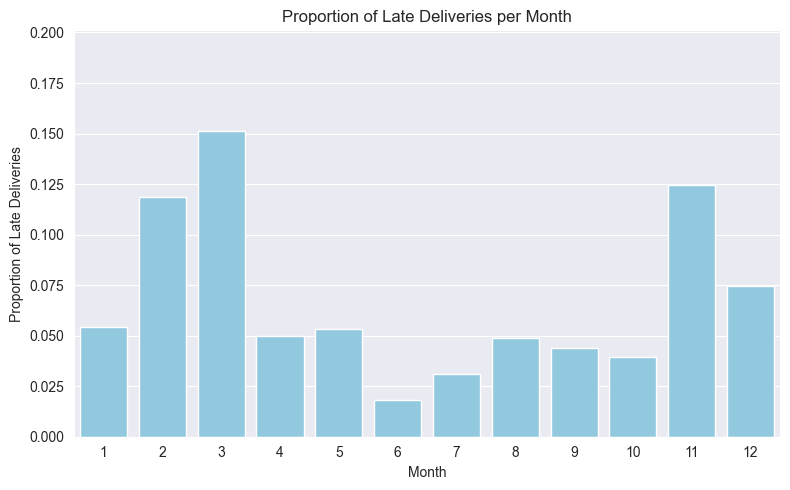

In [57]:
plt.figure(figsize=(8,5))
sns.barplot(data=late_by_month, x='order_month', y='is_late', color='skyblue')
plt.xticks(range(0,12), range(1,13))
plt.ylabel("Proportion of Late Deliveries")
plt.xlabel("Month")
plt.title("Proportion of Late Deliveries per Month")
plt.ylim(0, late_by_month['is_late'].max() + 0.05)
plt.tight_layout()
plt.show()
## ---> order are more delayed on March and in November ! and very on time in June

#### Influence of 'order_day_of_week'

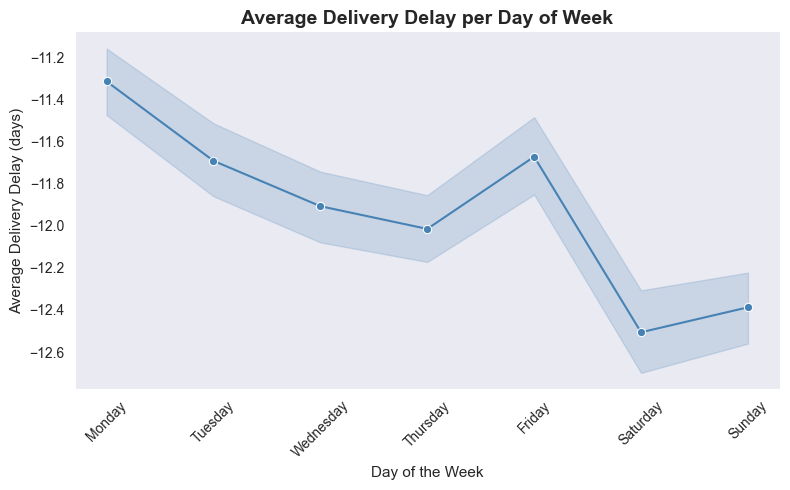

In [58]:
### line plot delivery_delay vs. 'order_day_of_week'
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'] # Define weekday labels
plt.figure(figsize=(8,5))
sns.lineplot(
    data=df_orders,
    x='order_day_of_week',
    y='delivery_delay',
    marker='o',
    color='steelblue'
)
plt.title("Average Delivery Delay per Day of Week", fontsize=14, weight='bold')
plt.xlabel("Day of the Week", fontsize=11)
plt.ylabel("Average Delivery Delay (days)", fontsize=11)
plt.xticks(ticks=range(7), labels=days, rotation=45)# Replace numeric x-axis ticks with weekday names
# Remove background grid and set clean white background
sns.despine()
plt.grid(False)
plt.tight_layout()
plt.show()
## ---> order are more delayed on fridays ! Actually they are less "in advance" on Fridays because all are in the negative values


In [59]:
## this pattern does not show up when looking at the proportion of late delivery
late_by_day = df_orders.groupby('order_day_of_week')['is_late'].mean().reset_index()
print(late_by_day)

   order_day_of_week   is_late
0                  0  0.074209
1                  1  0.070256
2                  2  0.065563
3                  3  0.062776
4                  4  0.070032
5                  5  0.065682
6                  6  0.062489


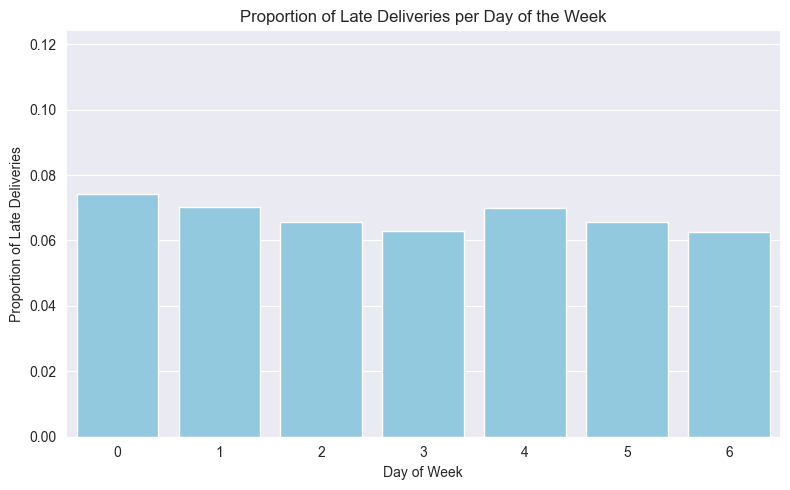

In [60]:
### bar plot delivery_delay vs. 'order_day_of_week'
plt.figure(figsize=(8,5))
sns.barplot(data=late_by_day, x='order_day_of_week', y='is_late', color='skyblue')
plt.ylabel("Proportion of Late Deliveries")
plt.xlabel("Day of Week")
plt.title("Proportion of Late Deliveries per Day of the Week")
plt.ylim(0, late_by_day['is_late'].max() + 0.05)
plt.tight_layout()
plt.show()

#### Influence of 'order_year'

In [ ]:
## compute delay per year
delay_by_year = df_orders.groupby('order_year')['delivery_delay'].mean().reset_index()
print(delay_by_year)

   order_year  delivery_delay
0        2016      -36.620301
1        2017      -12.339403
2        2018      -11.381388


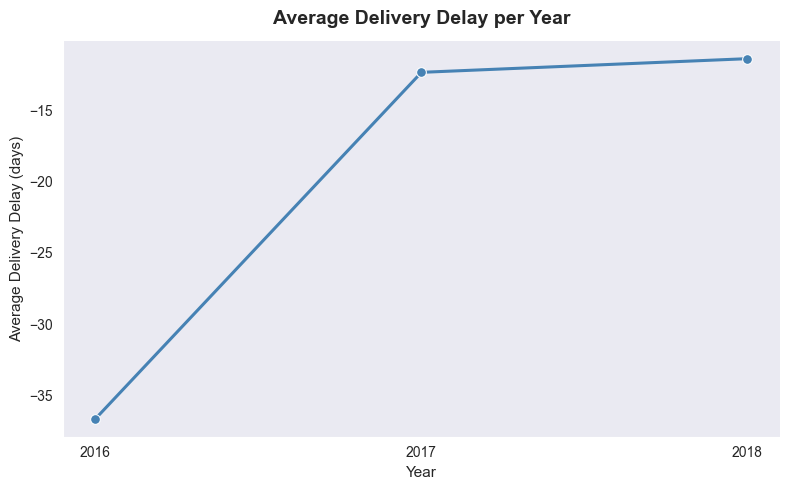

In [61]:
# Plot
plt.figure(figsize=(8,5))
sns.lineplot(
    data=delay_by_year,
    x='order_year',
    y='delivery_delay',
    marker='o',
    color='steelblue',
    linewidth=2.2,
    markersize=7
)
plt.title("Average Delivery Delay per Year", fontsize=14, weight='bold', pad=12)
plt.xlabel("Year", fontsize=11)
plt.ylabel("Average Delivery Delay (days)", fontsize=11)
# Style adjustments
sns.despine()           # remove top/right spines
plt.grid(False)          # remove grid background (clean look)
# Ensure full year labels shown
plt.xticks(delay_by_year['order_year'])
plt.tight_layout()
plt.show()

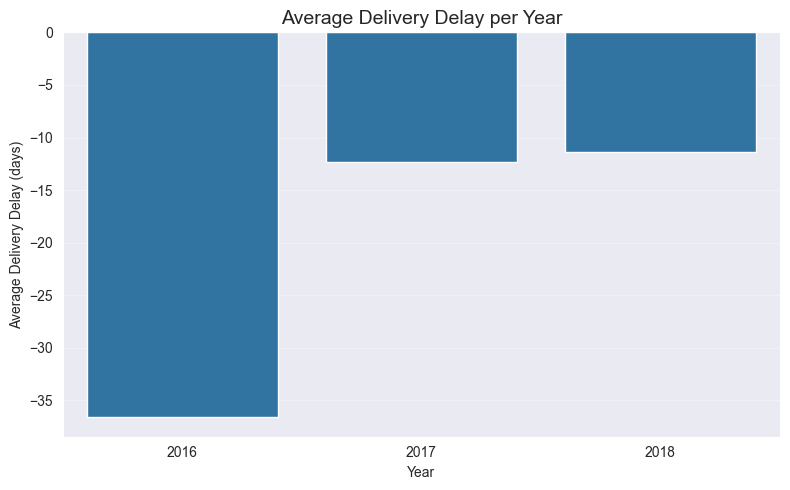

In [62]:
### make it a barplot:
plt.figure(figsize=(8,5))
sns.barplot(data=delay_by_year,x='order_year',y='delivery_delay',)
plt.title("Average Delivery Delay per Year", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Average Delivery Delay (days)")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
## ---> In 2016, order arrived significantly earlier than in 2017 and 2018

In [63]:
late_by_year = df_orders.groupby('order_year')['is_late'].mean().reset_index()
print(late_by_year)

   order_year   is_late
0        2016  0.007519
1        2017  0.056432
2        2018  0.077062


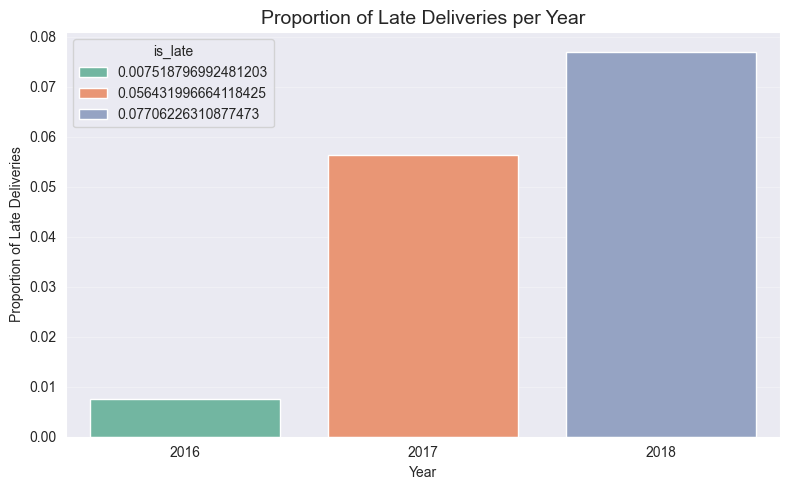

In [64]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=late_by_year,
    x='order_year',
    y='is_late',
    hue='is_late',
    palette='Set2'
)
plt.title("Proportion of Late Deliveries per Year", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Proportion of Late Deliveries")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

#### iInfluence of 'distance_category'

In [65]:
df_orders.distance_category.value_counts()

#### barplot long distance vs not long distance:
df_orders['long_distance_flag'] = df_orders['distance_category'] == 'Long Distance'
df_orders['long_distance_flag'] = df_orders['long_distance_flag'].map({True: 'Long Distance', False: 'Not Long Distance'})
avg_late = df_orders.groupby('long_distance_flag')['is_late'].mean().reset_index()
print(avg_late)

  long_distance_flag   is_late
0      Long Distance  0.104312
1  Not Long Distance  0.060603


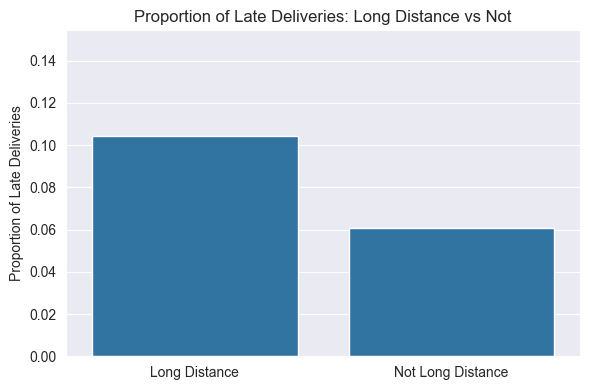

In [66]:
plt.figure(figsize=(6,4))
sns.barplot(data=avg_late, x='long_distance_flag', y='is_late')
plt.ylabel("Proportion of Late Deliveries")
plt.xlabel("")
plt.title("Proportion of Late Deliveries: Long Distance vs Not")
plt.ylim(0, avg_late['is_late'].max() + 0.05)  # optional: leave some space above bars
plt.tight_layout()
plt.show()
### ---> the long distance delivery are twice as often late than the other distance categories

In [69]:
### delivery delay per distance category
delay_by_distance = df_orders.groupby('distance_category')['delivery_delay'].mean().reset_index()
print(delay_by_distance)

  distance_category  delivery_delay
0             Local       -9.517292
1     Long Distance      -12.789875
2          National      -12.691148
3          Regional      -12.087188


  distance_category  delivery_delay
0             Local       -9.517292
1     Long Distance      -12.789875
2          National      -12.691148
3          Regional      -12.087188


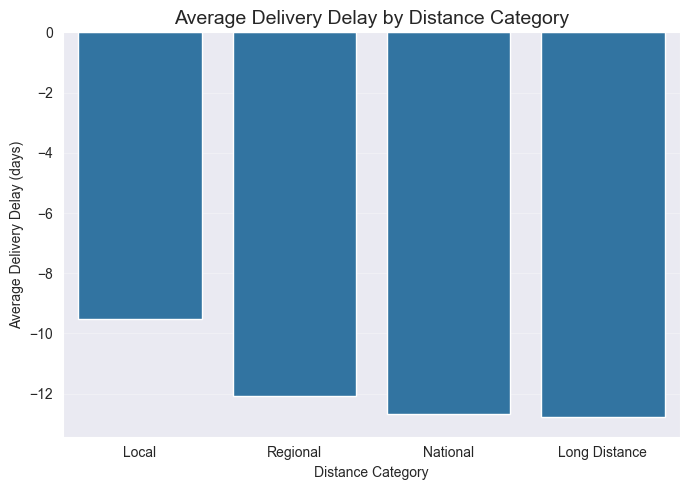

In [67]:
plt.figure(figsize=(7,5))
sns.barplot(
    data=delay_by_distance,
    x='distance_category',
    y='delivery_delay',
    order=['Local','Regional','National','Long Distance']  # optional order
)
plt.title("Average Delivery Delay by Distance Category", fontsize=14)
plt.xlabel("Distance Category")
plt.ylabel("Average Delivery Delay (days)")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
### ---> the difference is actually between the 'local' and the other categories

In [68]:
### Proportion of late delivery per distance category
late_by_distance = df_orders.groupby('distance_category')['is_late'].mean().reset_index()
print(late_by_distance)

  distance_category   is_late
0             Local  0.044432
1     Long Distance  0.104312
2          National  0.071226
3          Regional  0.061039


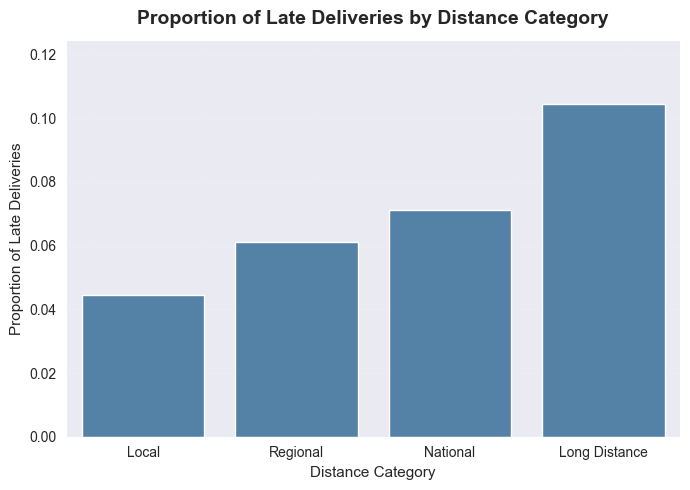

In [70]:
plt.figure(figsize=(7,5))
sns.barplot(
    data=late_by_distance,
    x='distance_category',
    y='is_late',
    order=['Local','Regional','National','Long Distance'],
    color='steelblue'  # match the previous plots' color
)
plt.title("Proportion of Late Deliveries by Distance Category", fontsize=14, weight='bold', pad=12)
plt.xlabel("Distance Category", fontsize=11)
plt.ylabel("Proportion of Late Deliveries", fontsize=11)
sns.despine()
plt.grid(axis='y', linestyle='--', alpha=0.2)   # subtle horizontal guides only
plt.ylim(0, late_by_distance['is_late'].max() + 0.02)
plt.tight_layout()
plt.show()

#### Influence of 'days_since_last_order' (i.e. Frequency)

/var/folders/p_/2z_4h86x4xn1vn6dsptg3n000000gn/T/ipykernel_37107/542523098.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_orders.groupby('days_bin')['is_late']


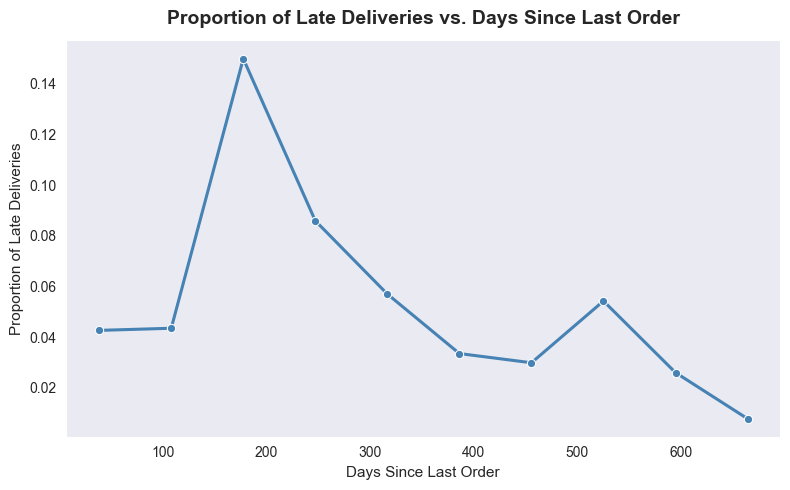

In [71]:
# Bin 'days_since_last_order' into groups (adjust bin size as needed)
df_orders['days_bin'] = pd.cut(df_orders['days_since_last_order'], bins=10)

# Compute proportion of late deliveries per bin
delay_by_bin = (
    df_orders.groupby('days_bin')['is_late']
    .mean()
    .reset_index()
)

# Compute midpoints of bins for plotting
delay_by_bin['days_mid'] = delay_by_bin['days_bin'].apply(lambda x: x.mid)

plt.figure(figsize=(8,5))
sns.lineplot(
    data=delay_by_bin,
    x='days_mid',
    y='is_late',
    marker='o',
    color='steelblue',
    linewidth=2.2
)

plt.title("Proportion of Late Deliveries vs. Days Since Last Order", fontsize=14, weight='bold', pad=12)
plt.xlabel("Days Since Last Order", fontsize=11)
plt.ylabel("Proportion of Late Deliveries", fontsize=11)
sns.despine()
plt.grid(False)
plt.tight_layout()
plt.show()

---> uneasy to interpret
Customers who haven’t ordered for around 5–7 months (bin (143.0, 212.5]) show the highest likelihood of late deliveries (~15%).
However, for customers inactive for nearly a year, the delay rate decreases again.
This suggests that delivery delay is not strictly linear with purchase recency and may reflect distinct customer segments
or changes in logistics performance over time.